<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 2 / NOTE 1*

# 📝 Assignment
---

# Decision Trees(결정트리)

## 캐글 인클래스(InClass) Competitions

### 1) 대회 참여(Join) 및 데이터셋 준비

- [캐글 계정을 만드세요](https://www.kaggle.com/), 공유된 인클래스 대회 url을 통해 이동한 후 대회에 참여하세요.
- H1N1 데이터를 훈련/검증/테스트 셋으로 나누어 준비하세요
- **(객관식) 훈련데이터셋을 사용해 H1N1 타겟으로 기준모델을 설정하세요. 기준모델의 정확도를 제출하세요.**
    1. 0.24
    2. 0.50
    3. 0.76
    4. 1


In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json
# !pip install kaggle

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
# 데이터 불러오기
target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [4]:
sample_submission.head()

,Id,vacc_h1n1_f
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


In [5]:
train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state,vacc_h1n1_f
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10 - 17 Years,NaN,3,1,2,NaN,2.0,NaN,4,"MSA, Not Principle City",2.0,3.0,5.0,NaN,NaN,9,CALIFORNIA,0
1,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Somewhat Low,Not At All Worried,45 - 54 Years,3.0,3,1,2,2.0,1.0,Employed,2,"MSA, Principle City",1.0,0.0,1.0,Accommodation and Food Services Industries,Food Preparation and Serving Related Occupations,7,NEBRASKA,0
2,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Very Worried,Somewhat Effective,Somewhat Low,Very Worried,45 - 54 Years,3.0,3,1,2,2.0,2.0,Employed,1,"MSA, Not Principle City",1.0,2.0,3.0,Transportation and Warehousing Industries,Transportation and Material Moving Occupations,1,MASSACHUSETTS,0
3,2.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Very High,Not At All Worried,35 - 44 Years,4.0,1,2,1,1.0,1.0,Employed,3,"MSA, Not Principle City",2.0,2.0,4.0,"Professional, Scientific, and Technical Servic...",Legal Occupations,6,LOUISIANA,0
4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Very Effective,Very Low,Not At All Worried,Not At All Effective,Very Low,Not At All Worried,55 - 64 Years,3.0,3,2,2,1.0,1.0,Employed,3,"MSA, Not Principle City",3.0,0.0,3.0,Education Services Industries,Office and Administrative Support Occupations,4,ALABAMA,1


In [6]:
# 훈련 / 검증 / 테스트 셋으로 분리
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [7]:
# 기준 모델 설정
train[target].value_counts(normalize=True)
# 기준 모델 정확도 : 0.760935

0    0.760935
1    0.239065
Name: vacc_h1n1_f, dtype: float64

### 2) 데이터 EDA 및 특성공학 수행
- profiling을 사용하여 데이터를 살펴보고, missing value, zeros, cardinarity 등을 확인하여 처리하세요.
- 본인만의 특성공학을 수행하세요.


In [8]:
# ! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
from pandas_profiling import ProfileReport

In [ ]:
# profile = ProfileReport(train, minimal=True).to_notebook_iframe()

In [10]:
train.T.duplicated()

h1n1_concern                   False
h1n1_knowledge                 False
behavioral_antiviral_meds      False
behavioral_avoidance           False
behavioral_face_mask           False
behavioral_wash_hands          False
behavioral_large_gatherings    False
behavioral_outside_home        False
behavioral_touch_face          False
doctor_recc_h1n1               False
doctor_recc_seasonal           False
chronic_med_condition          False
child_under_6_months           False
health_insurance               False
health_worker                  False
opinion_h1n1_vacc_effective    False
opinion_h1n1_risk              False
opinion_h1n1_sick_from_vacc    False
opinion_seas_vacc_effective    False
opinion_seas_risk              False
opinion_seas_sick_from_vacc    False
agegrp                         False
education_comp                 False
raceeth4_i                     False
sex_i                          False
inc_pov                        False
marital                        False
r

In [11]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
employment_status,25466,3,Employed,13722
census_msa,33723,3,"MSA, Not Principle City",15202
opinion_h1n1_vacc_effective,26637,6,Somewhat Effective,11710
opinion_h1n1_risk,26602,6,Somewhat Low,9980
opinion_h1n1_sick_from_vacc,26568,6,Not Very Worried,9229
opinion_seas_vacc_effective,26519,6,Somewhat Effective,11571
opinion_seas_risk,26466,6,Somewhat Low,9057
opinion_seas_sick_from_vacc,26413,6,Not At All Worried,11813
agegrp,33723,7,65+ Years,6821
employment_industry,13714,23,Health Care and Social Assistance Industries,2451


In [12]:
import numpy as np

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    df = df[selected_features]
    
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    
    dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

In [13]:
features = train.drop(columns=[target]).columns

In [14]:
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]


### 3) 모델링 수행
- 결정트리를 학습시킵니다. 하이퍼파라미터를 수정하여 성능을 높여보세요. 과적합을 주의하세요!
- 검증세트 스코어를 확인하세요.(평가지표는 F1-score입니다, 수식은 캐글 Overview-Evaluation 페이지를 확인해 주세요. 평가지표에 대한 내용은 다음에 자세히 배우고 활용할 것입니다 지금은 스코어를 올리기 위한 노력을 전혀 기울이지 말고 결정트리의 개념과 코드이해, 사용에 집중하세요!)
- 특성중요도를 그래프로 나타내 보세요
- **검증세트의 F1-score를 제출하세요. (0.5 이상 통과)**

In [ ]:
# ! pip install category_encoders

In [18]:
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


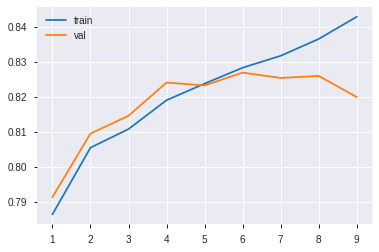

In [19]:
train_score = []
val_score = []
for i in np.arange(1, 10):
  pipe = make_pipeline(
      OneHotEncoder(use_cat_names=True),  
      SimpleImputer(), 
      DecisionTreeClassifier(max_depth = i, random_state=1)
  )

  pipe.fit(X_train, y_train)
  train_score.append(pipe.score(X_train, y_train))
  val_score.append(pipe.score(X_val, y_val))
  # print('훈련 정확도: ', pipe.score(X_train, y_train))
  # print('검증 정확도: ', pipe.score(X_val, y_val))

plt.plot(np.arange(1, 10), train_score, label='train')
plt.plot(np.arange(1, 10), val_score, label='val')
plt.legend()
plt.show()

# max_depth = 6

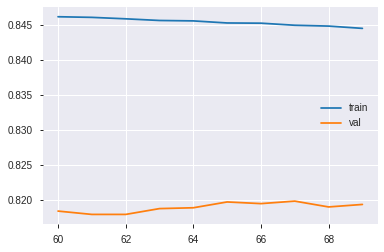

In [20]:
train_score = []
val_score = []
count_number = np.arange(60, 70)
for i in count_number:
  pipe = make_pipeline(
      OneHotEncoder(use_cat_names=True),  
      SimpleImputer(), 
      DecisionTreeClassifier(min_samples_split = i, random_state=1)
  )

  pipe.fit(X_train, y_train)
  train_score.append(pipe.score(X_train, y_train))
  val_score.append(pipe.score(X_val, y_val))
  # print('훈련 정확도: ', pipe.score(X_train, y_train))
  # print('검증 정확도: ', pipe.score(X_val, y_val))

plt.plot(count_number, train_score, label='train')
plt.plot(count_number, val_score, label='val')
plt.legend()
plt.show()

# min_samples_split = 65

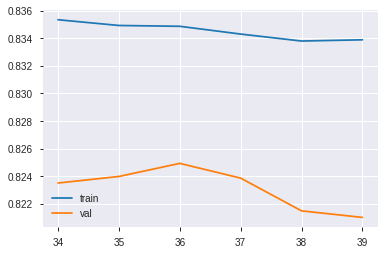

In [21]:
train_score = []
val_score = []
count_number = np.arange(34, 40)
for i in count_number:
  pipe = make_pipeline(
      OneHotEncoder(use_cat_names=True),  
      SimpleImputer(), 
      DecisionTreeClassifier(min_samples_leaf = i, random_state=1)
  )

  pipe.fit(X_train, y_train)
  train_score.append(pipe.score(X_train, y_train))
  val_score.append(pipe.score(X_val, y_val))
  # print('훈련 정확도: ', pipe.score(X_train, y_train))
  # print('검증 정확도: ', pipe.score(X_val, y_val))

plt.plot(count_number, train_score, label='train')
plt.plot(count_number, val_score, label='val')
plt.legend()
plt.show()

# min_samples_leaf = 36

In [22]:
# 결정 트리 학습
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf = 36, random_state=1)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

훈련 정확도:  0.8348604809773745
검증 정확도:  0.8249317993120626


In [23]:
# 훈련 정확도:  0.8283367434688491
# 검증 정확도:  0.8269481674771676
# 0.5401827923101167

# 훈련 정확도:  0.8452688076387036
# 검증 정확도:  0.8197129640612028
# 0.5568513119533527

# 훈련 정확도:  0.8348604809773745
# 검증 정확도:  0.8249317993120626
# 0.5651149086623453

In [24]:
# F1 Score
y_pred = pipe.predict(X_val)

f1_score(y_val, y_pred)

0.5651149086623453

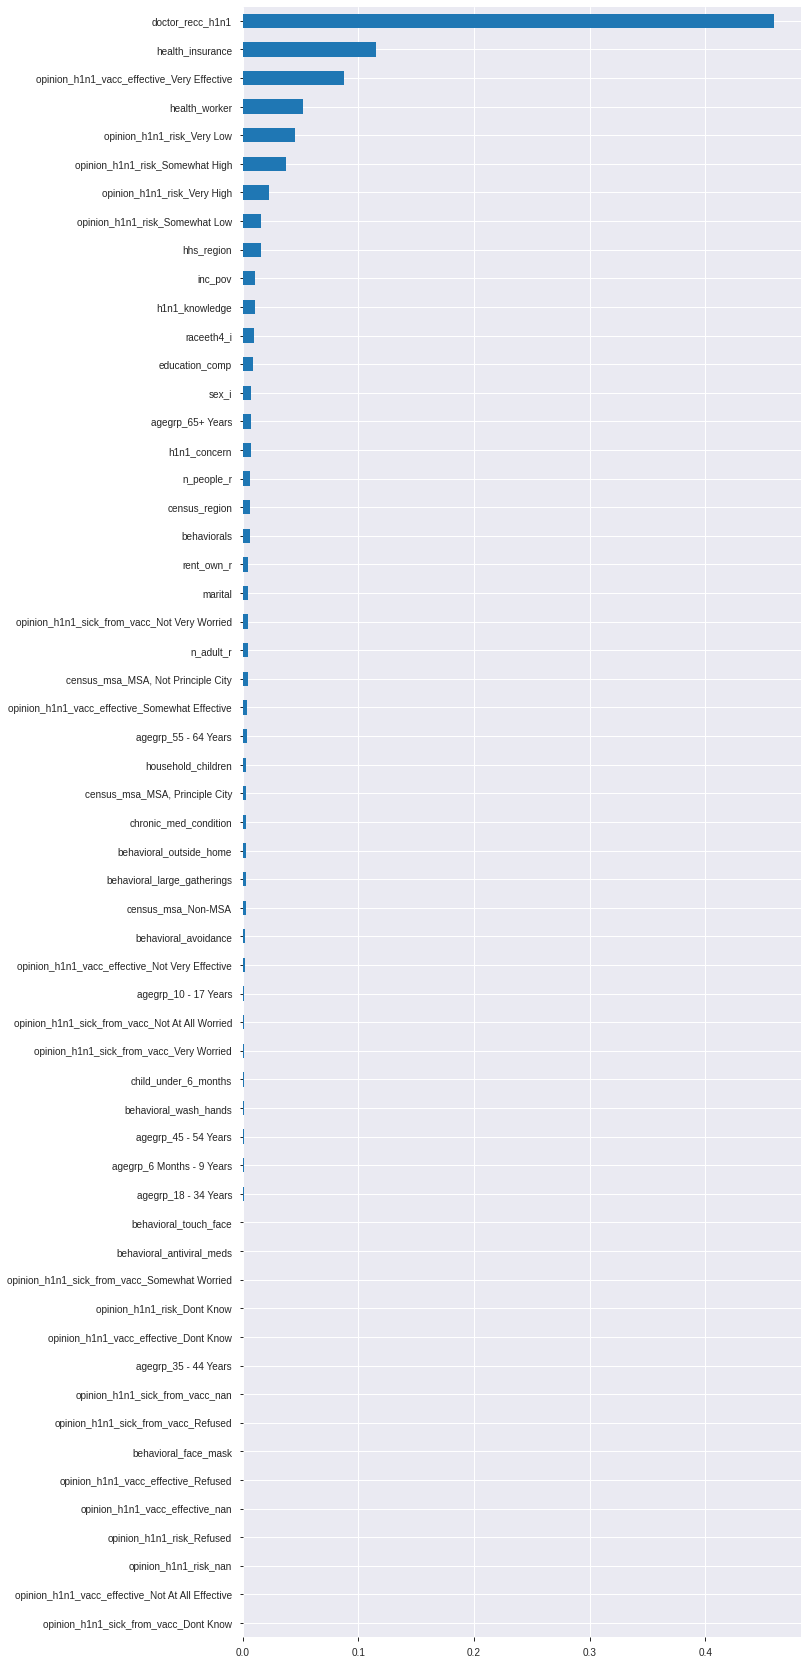

In [25]:
# 특성 중요도 그래프
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns
model_dt = pipe.named_steps['decisiontreeclassifier']

importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

### 4) 테스트셋 예측 결과 제출(Submission)

- 테스트셋에 대한 예측 결과를 캐글에 제출 하세요.(스코어가 많이 낮게 나와도 결정트리를 잘 이해하고 결과를 내었다면 충분합니다!)
- **캐글 Leaderboard의 본인 Score를 제출하세요.**
 

In [26]:
X_total = pd.concat([X_train, X_val])
y_total = pd.concat([y_train, y_val])

In [27]:
# 최종 모델 학습
last_pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(min_samples_leaf = 36, random_state=1)
)

last_pipe.fit(X_total, y_total)
print('최종 정확도: ', last_pipe.score(X_total, y_total))

최종 정확도:  0.8355790672296817


In [28]:
# 최종 모델 학습 후 테스트 셋에 대한 예측 결과
y_test_pred = last_pipe.predict(X_test)

In [29]:
# 최종 결과 담은 데이터프레임 생성
d = {'Id':X_test.index, 'vacc_h1n1_f': y_test_pred}
submission = pd.DataFrame(data = d)
submission.head()

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [30]:
# 제출용 파일 생성
submission.to_csv('submission.csv', index=False)

In [ ]:
# !kaggle competitions submit -c prediction-of-h1n1-vaccination -f submission.csv -m "Gyeong ho Ahn, First Submission - fixed"

## 🔥 도전과제

### 4) 다른 종류의 imputer를 사용하고 특성-타겟 관계 그래프를 나타내 보세요.
- 다른 종류의 imputer를 사용해 보세요([scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html))
- seaborn plots 사용하여 관심있는 특성들과 target간의 관계를 그래프로 나타내 보세요.
- [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html)
- [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html)

In [32]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns

In [33]:
# 범주형 특성 변환
encoder = OneHotEncoder()
X_train_oh = encoder.fit_transform(X_train)
X_val_oh = encoder.transform(X_val)
X_test_oh = encoder.transform(X_test)

In [34]:
# 비교 목적
imputer = SimpleImputer(strategy='most_frequent') # 수치형이 아닌 범주형이므로 기본값(평균)이 아닌 최빈값으로 대체
X_train_imp = imputer.fit_transform(X_train_oh)
X_val_imp = imputer.transform(X_val_oh)
X_test_imp = imputer.transform(X_test_oh)

In [35]:
X_train_imp

array([[ 1.,  1.,  0., ...,  4.,  2.,  0.],
       [ 1.,  1.,  0., ...,  4.,  7.,  5.],
       [ 2.,  2.,  0., ...,  1., 10.,  4.],
       ...,
       [ 2.,  1.,  0., ...,  3.,  4.,  0.],
       [ 2.,  1.,  0., ...,  4.,  8.,  0.],
       [ 2.,  1.,  0., ...,  2.,  4.,  3.]])

In [36]:
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train_oh.columns)
X_val_imp = pd.DataFrame(X_val_imp, columns=X_val_oh.columns)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test_oh.columns)

In [37]:
# 새로운 imputer
itr_imputer = IterativeImputer(initial_strategy='most_frequent')
X_train_itrimp = itr_imputer.fit_transform(X_train_oh)
X_val_itrimp = itr_imputer.transform(X_val_oh)
X_test_itrimp = itr_imputer.transform(X_test_oh)

In [38]:
X_train_itrimp

array([[ 1.        ,  1.        ,  0.        , ...,  4.        ,
         2.        ,  0.        ],
       [ 1.        ,  1.        ,  0.        , ...,  4.        ,
         7.        ,  5.        ],
       [ 2.        ,  2.        ,  0.        , ...,  1.        ,
        10.        ,  4.        ],
       ...,
       [ 1.15038918,  0.96142648, -0.03272829, ...,  3.        ,
         4.        ,  0.        ],
       [ 1.08467064,  1.08072912, -0.03218227, ...,  4.        ,
         8.        ,  0.        ],
       [ 2.        ,  1.        ,  0.        , ...,  2.        ,
         4.        ,  3.        ]])

In [39]:
X_train_itrimp = pd.DataFrame(X_train_itrimp, columns=X_train_oh.columns)
X_val_itrimp = pd.DataFrame(X_val_itrimp, columns=X_val_oh.columns)
X_test_itrimp = pd.DataFrame(X_test_itrimp, columns=X_test_oh.columns)

In [40]:
# 보고 싶은 특성 선택
cols = ['doctor_recc_h1n1', 'health_insurance', 'health_worker', 'education_comp', 'raceeth4_i', 'inc_pov']

# 1. SimpleImputer 사용한 경우
df_imp = pd.concat([X_train_imp[cols], y_train], axis=1)
df_imp.shape

(40426, 7)

In [41]:
hue_title = ['Recommended by a doctor?', 'Have health insurance?', 'Healthcare worker?', 'Edu level', 'Race', 'Income']
hue = [['Not Recommended', 'Recommended'], ['No', 'Yes'], ['No', 'Yes'], ['Under 12 Years', '12 Years', 'Some College', 'College Graduate'],
      ['Hispanic','Non-Hispanic, Black Only','Non-Hispanic, White Only','Non-Hispanic, Other or Multiple Races'],
       ['Over $75,000', '$75,000 or Less', 'Below Poverty', 'Unknown']]

def visualize_imp_df(df):
  fig, axes = plt.subplots(2, 3, figsize=(20, 10))
  axes = axes.flatten()

  for i, col in enumerate(cols):
    tmp = df.groupby(col)[['vacc_h1n1_f']].count()
    tmp = tmp.reset_index()
    tmp[hue_title[i]] = hue[i]

    sns.barplot(ax = axes[i], data=tmp, x=col, y='vacc_h1n1_f', hue=hue_title[i])

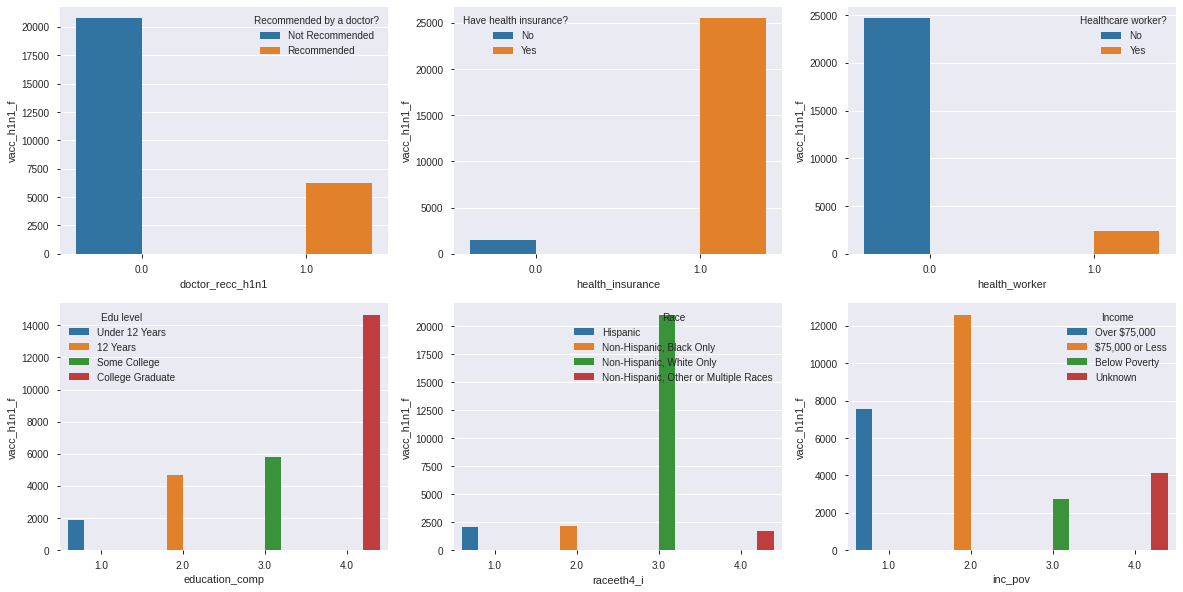

In [42]:
visualize_imp_df(df_imp)

In [43]:
# 2. IterativeImputer 사용한 경우
df_itrimp = pd.concat([X_train_itrimp[cols], y_train], axis=1)
df_itrimp.head()

,doctor_recc_h1n1,health_insurance,health_worker,education_comp,raceeth4_i,inc_pov,vacc_h1n1_f
0,0.0,0.794106,0.0,4.0,3.0,1.0,0.0
1,1.0,1.000000,0.0,2.0,3.0,3.0,0.0
2,0.0,1.000000,0.0,1.0,3.0,2.0,0.0
3,0.0,1.000000,0.0,4.0,3.0,1.0,0.0
4,0.0,0.819239,0.0,4.0,3.0,2.0,1.0


In [44]:
# fig, axes = plt.subplots(2, 3, figsize=(20, 10))
# axes = axes.flatten()

# for i, col in enumerate(cols):
#   tmp = df_itrimp.groupby(col)[['vacc_h1n1_f']].count()
#   tmp = tmp.reset_index()
#   # tmp[hue_title[i]] = hue[i]

#   sns.barplot(ax = axes[i], data=tmp, x=col, y='vacc_h1n1_f', hue=col)

# IterativeImputer에서 initial_strategy='most_frequent'로 설정해도 범주형 값이 0 또는 1이 아닌 다른 값으로 대체됨
# 이로 인해 위 SimpleImputer와 동일한 방식으로 그래프 출력 불가능...